<a href="https://colab.research.google.com/github/flecumberry/seys/blob/master/seys_simulacion_sistema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulación y verificación de un SLIT
Simularemos el sistema propuesto en el ejercicio 10 del práctico 2. Para la simulación nos basaremos en la ecuación en diferencias. Validaremos la salida de la respuesta calculada en el ejercicio comparando contra la salida simulada. Generamos algunas funciones auxiliares.

El programa principal comparará la salida a una entrada con la forma de un pulso.


In [0]:
"""

Señales y Sistemas, 2019. IIE-FIng-Udelar.
@author: Federico Lecumberry

"""
# Importar funciones necesarias
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Escalón (u[n]).
# =============================================================================
def escalon(n):
    return np.heaviside(n,1)

# =============================================================================
# Retardo (y[n] = x[n-M]).
# Se repite el valor en los bordes.
# =============================================================================
def retardo(x,M):
    if M > 0:
        y = np.concatenate( (x[0]*np.ones(M), x[0:-M]) )
    elif M < 0:
        y = np.concatenate( (x[-M:], x[-1]*np.ones(-M)) )

    return y

# =============================================================================
# Pulso (x[n] = 1, 0 <= n <= M-1 y x[n] = 0, para todo otro n)
# =============================================================================
def pulso( M ):
    u0 = escalon( n )
    uM = retardo( u0, M )

    return (u0 - uM)
  
# =============================================================================
# Graficar la entrada y las salidas calculadas con ambos métodos.
# =============================================================================
def graficar( n, x, y, z ):
    my, sy, by = plt.stem( n, y, ':', label='Salida por ec. dif.' )
    mz, sz, bz = plt.stem( n, z, ':', label='Respuesta al pulso' )
    mx, sx, bx = plt.stem( n, x, label='Entrada' )
    
    plt.setp(my, color='b', markersize=6)
    plt.setp(mz, color='r', markersize=4)
    plt.setp(mx, color='k', markersize=6)
    plt.setp(sy, color='k', linewidth=1)
    plt.setp(sz, color='k', linewidth=1)
    plt.setp(sx, color='k', linewidth=1)
    plt.setp(by, color='k', linewidth=1)
    plt.setp(bz, color='k', linewidth=1)
    plt.setp(bx, color='k', linewidth=1)
    plt.legend()


## Simulación por la ecuación en diferencias
La ecuación en diferencia que simularemos modela la carga de una batería en el instante $n$ ($y[n]$):
$$y[n]=0.95y[n-1]+x[n]$$
De esta forma podemos calcular la respuesta del sistema a *cualquier* señal $x[n]$ con valores nulos para $n<0$.

En la práctica, la batería tiene una carga máxima (`carga_max`) más allá de la cuál la batería no aumenta la carga ($y[n]$). Tampoco puede tener una carga negativa, por lo que definiremos una carga mínima (`carga_min`). Estas limitaciones agregan transformaciones **no lineales** que no podemos modelar con las herramientas del curso. Estas restricciones están incluidas en la simulación pero con los parámetros por defecto no tienen efecto.

In [0]:
# =============================================================================
# Definición del sistema por su ecuación en diferencias.
#
# La carga máxima y mínima de la batería no está modelada en la ecuación del 
# sistema dado que es una no linealidad, sin embargo lo dejamos accesible para 
# poder ver el efecto.
# =============================================================================
def sistema_ecuacion_diferencias( x, n ):    
    carga_max = 5;
    carga_min = 0;
    N = np.size(n)
    y = np.zeros( N )
    for i in range( N ):
        if n[i] < 0: 
            y[i] = 0
        else:
            temp = 0.95*y[i-1] + x[i];
            # Aquí agregamos los límites de la batería.
            y[i] = max( carga_min, min( carga_max, temp) )
    return y

## Cáculo de la respuesta a un escalón
Conociendo la respuesta al impulso $$h[n]=0.95^nu[n]$$ podemos calcular de form cerrada la respuesta a una entrada $x[n]$. La expresión de la salida a la entrada $$x[n]=u[n]$$ es $$y[n]=\frac{1-0.95^{n+1}}{0.05}u[n].$$

Esta salida la simulamos en la función `sistema_respuesta_pulso(M,vn)` donde $M$ es el ancho del pulso que comienza en $n=0$ y $vn$ es el vector de tiempos en que se evalúa la salida.


In [0]:
# =============================================================================
# Respuesta al pulso. Respuesta calculada a un pulso de ancho M que comienza en
# n = 0.
# =============================================================================
def sistema_respuesta_pulso( M, n ):
    N = np.size( n )
    z = np.zeros( N )
    u0 = escalon( n )
    uM = retardo( u0, M )
    for i in range( N ):
        if n[i] < 0:
            z[i] = 0
        else:
            z[i] = (1-0.95**(n[i]+1))/0.05*u0[i] - (1-0.95**(n[i]+1-M))/0.05*uM[i];
    return z

## Ejecución del programa
La estructura es la siguiente:
1. Definir las variables.
1. Crear pulso de carga y descarga.
1. Armar entrada como combinación lineal de ambos, $x[n]$
1. Obtener la salida mediante la simulación con la ecuación en diferencias, $y[n]$
1. Obtener la salida mediante (combinación lineal de) la ecuación de respuesta al pulso calculada, $z[n]$.
1. Graficar los resultados.



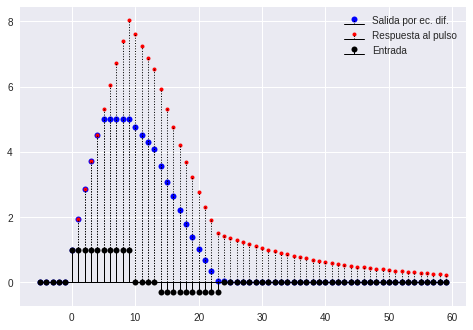

In [9]:
# Vector de tiempos. La carga comienza en n=0.
n = np.arange(-5, 60)

# Tiempo (ancho del pulso) de carga de la batería.
# Mc = 10
Mc = 10 #@param {type:"slider", min:1, max:20, step:1}

# Tiempo (ancho de pulso) de descarga de la batería.
Md = 10 #@param {type:"slider", min:1, max:20, step:1}

# Instante en que comienza la descarga.
Mr = 14

# Coeficiente para la combinación de pulso de carga y descarga.
A = 1
B = -0.3

# Pulso de carga. Comienza en n = 0 y tiene Mc puntos.
xc = pulso(Mc)

# Pulso de descarga. Comienza en n = Mr y tiene Md puntos.
xd = retardo( pulso( Md ), Mr )

# Preparar la entrada como la combinación lineal de una carga y una descarga.
x = A*xc + B*xd

# Respuesta del sistema calculado por la ecuación en diferencias.
y = sistema_ecuacion_diferencias( x, n )

# Respuesta del sistema a un pulso calculada. Lo calculamos como la combinación
# lineal de salidas a los pulsos.
z1 = sistema_respuesta_pulso( Mc, n )
z2 = sistema_respuesta_pulso( Md, n )
z2 = retardo( z2, Mr )
z = A*z1 + B*z2

# Graficar
graficar( n, x, y, z )

# Pruebas

Variando los parámetros se lleva el sistema a otras situaciones, varias de ellas se pueden interpretar como la respuesta de la batería mientras el modelo se ajuste.

* ¿Qué pasa si se descarga durante mucho tiempo?
* ¿Qué pasa si se reduce el valor de la `carga_max` de la bateria y el modelo deja de ser válido?

